In [2]:
import numpy as np
import math
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import *
import matplotlib.pyplot as plt
sys.path.insert(0, '/Users/skhan/athena/vis/python')
import athena_read

In [3]:
# Given parameters
r_min = 0.3
r_max = 5.0
N_r = 384
# Calculate x1 ratio for a log-uniform grid
x1 = (r_max / r_min) ** (1.0 / N_r)

# Print x1 to 15 decimal places
print(f"x1 = {x1:.15f}")


x1 = 1.007353495539222


In [149]:
data = athena_read.athdf('/Users/skhan/dust_sim2/disk.out1.00150.athdf')
dens = data.get('rho')[0]
dens_dust = data.get('dust_1_rho')[0]
r_c = data.get('x1v')
phi_c = data.get('x2v')
time = data.get('Time')
phi_f= data.get('x2f')
r_f = data.get('x1f')
v_r = data.get('vel1')[0]
v_phi = data.get('vel2')[0]
vortensity = data.get('user_out_var0')[0]

phi_c = phi_c[:,None]
d_phi = phi_f[:, None]
d_phi = d_phi[1:] - d_phi[:-1]
d_r = r_c[1:] - r_c[:-1]

In [127]:
time/(2.*np.pi)

np.float32(1500.001)

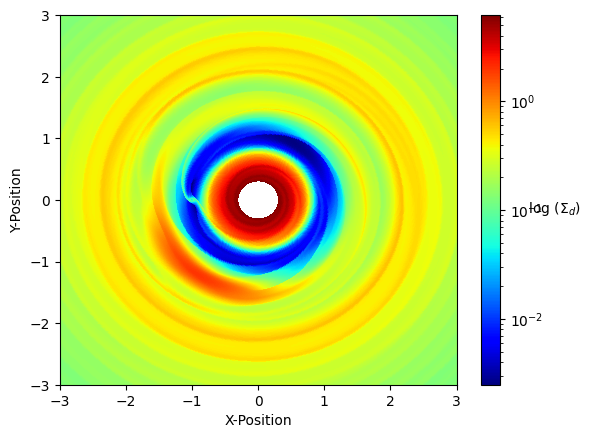

In [128]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), (dens), norm='log', cmap='jet')
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.xlim(-(1 + 2), 1 + 2)
plt.ylim(-(1 + 2), 1 + 2)
plt.colorbar().set_label(r'$\, \, \, \,$ log ($\Sigma_d$)', rotation=0)


ValueError: 'x' values must be equally spaced

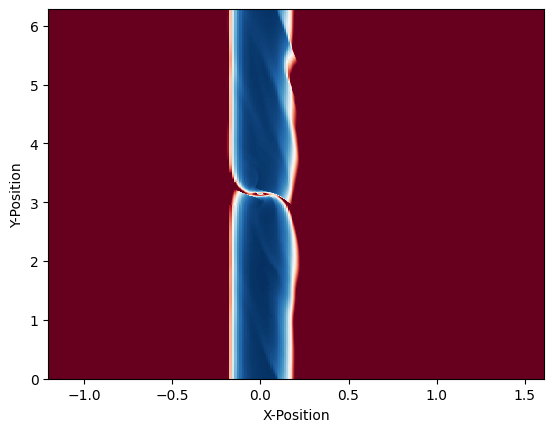

In [121]:
R, PHI = np.meshgrid(r_f, phi_f)
delta_sigma = dens - r_c**(-1.5)
dens_perturb = delta_sigma / r_c**(-1.5)

plt.pcolormesh(np.log(R), PHI, dens_perturb, cmap='RdBu_r', vmin = dens_perturb.min(), vmax = -0.95)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')

plt.streamplot(np.log(r_f), phi_f, v_r, v_phi)

plt.colorbar().set_label(r'log($\Sigma$)', rotation=90)

plt.ylim(0.3, 1.7)

/var/folders/d5/33p39bws6g11_rb56z3mb_vm001d4r/T/ipykernel_52373/2871191116.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto', vmin=0.0035, vmax=vmax)


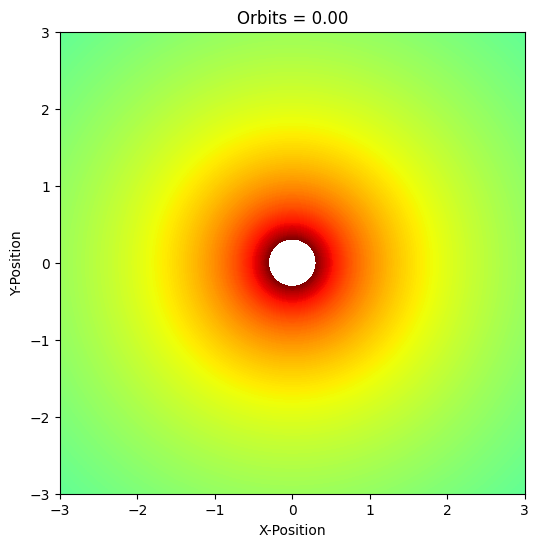

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_c, phi_c)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Optional: normalize color scale globally
vmin, vmax = None, None  # Set later

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    dens = data['rho'][0]  # [0] = first component (assumes 2D disk)

    # Set color scale range consistently
    if vmin is None or vmax is None:
        vmin = dens[dens > 0].min()
        vmax = dens.max()

    ax.clear()
    mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto', vmin=0.0035, vmax=vmax)
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie.gif", writer='pillow', fps=5)
# plt.show()


/var/folders/d5/33p39bws6g11_rb56z3mb_vm001d4r/T/ipykernel_30468/1670428167.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto')


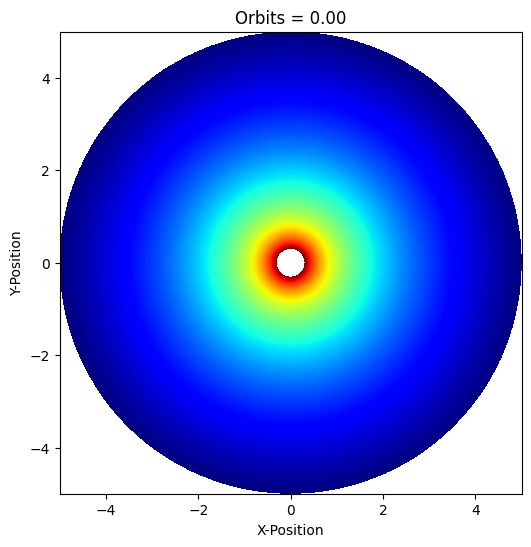

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_c, phi_c)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Optional: normalize color scale globally
vmin, vmax = None, None  # Set later

# Step 3: Set up the plot
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    dens = data['dust_1_rho'][0]  # [0] = first component (assumes 2D disk)

    # Set color scale range consistently
    if vmin is None or vmax is None:
        vmin = dens[dens > 0].min()
        vmax = dens.max()

    ax.clear()
    mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto')
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('square')
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie2.gif", writer='pillow', fps=5)
# plt.show()

$$\langle \frac{\delta \Sigma}{\Sigma_0} \rangle = \langle \frac{\Sigma - \Sigma_0}{\Sigma_0} \rangle$$

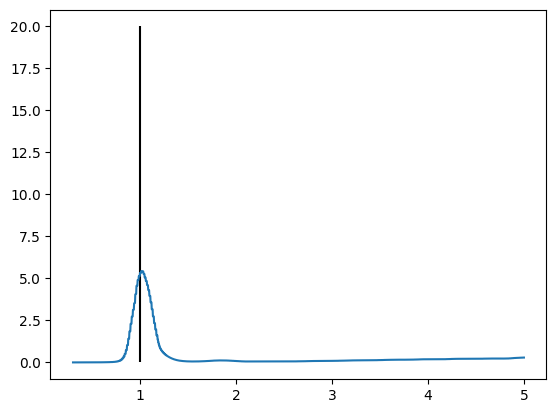

In [129]:
vortensity_0 = np.sqrt(1.0) / (2 * (r_c**(-1.5)))
plt.vlines(1.0, 0.0, 20, color='black')

plt.plot(r_c, np.average(vortensity, axis=0))

In [106]:
orbits = np.array([])
index = 0

for i in range(100, 140, 5):
    data = athena_read.athdf(f'/Users/skhan/dust_sim2/disk.out1.00{i}.athdf')
    dens = data.get('dust_1_rho')[0]
    orbits = np.append(orbits, np.round(data.get('Time') / (2 * np.pi), 2))
    dens_average = np.average(dens, axis=0)
    plt.plot(r_c, (dens_average), label=f'{int(orbits[index])} Orbits')
    index += 1

plt.xlabel('R')
plt.ylabel(r'$\Sigma_d$')

#plt.axhline(y=0, linestyle = 'dashed', color = 'black')

plt.tight_layout()
plt.legend()

KeyboardInterrupt: 

In [120]:
sum_dens_onesim = 0
for i in range(170,200,10):
    data = athena_read.athdf(f'/Users/skhan/dust_sim/disk.out1.00{i}.athdf')
    density = data.get('rho')[0]
    #d = initial(data.get('x1v'), data.get('x2v')[:,None], data.get('Time'), 1.0, 0.000954588, 0.000954588)[2]
    #density[d < 0.45 * initial(data.get('x1v'), data.get('x2v')[:,None], data.get('Time'), 1.0, 0.000954588,0.000954588)[3]] = 0
    sum_dens_onesim += density

sum_dens_avg_onesim = sum_dens_onesim/len(range(170,200,10))

In [8]:
dens_average = np.average(sum_dens_avg_onesim, axis=0)
plt.plot(r_c, (dens_average - r_c**(-1.5))/ (r_c**(-1.5)))
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel('log (R)')
plt.ylabel(r'$\langle \delta \Sigma / \Sigma_0 \rangle$')

plt.xscale('log')

NameError: name 'sum_dens_avg_onesim' is not defined

$$(\vec{\nabla} \times \vec{v})_z = \frac{1}{r} (\frac{\partial (r \vec{v_\varphi})}{\partial r} - \frac{\partial \vec{v_r}}{\partial \varphi}) \, \hat{k}$$

$$(\vec{\nabla} \times \vec{v}_K)_z = \frac{1}{\Sigma_0} \frac{1}{r} \frac{d}{dr} (r v_K)$$

In [201]:
r2d = r_c[np.newaxis, :]
drv_phi_dr = np.gradient(r2d * (np.sqrt(1.0/r_c)), r_c, axis=1)
curl_z = 1/(r_c**(-1.5)) * 1/r_c * drv_phi_dr
vortensity_0 = curl_z/dens

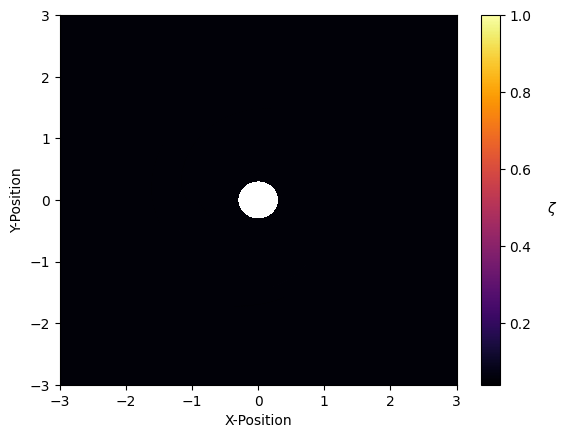

In [202]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), vortensity/vortensity_0, cmap='inferno', vmin=0.04, vmax=1.0)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.xlim(-(1 + 2), 1 + 2)
plt.ylim(-(1 + 2), 1 + 2)
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, $ $\zeta$', rotation=0)

In [168]:
(vortensity/vortensity_0).max()

np.float64(0.057201810933050115)

Text(0, 0.5, '$\\langle \\delta \\Sigma / \\Sigma_0 \\rangle$')

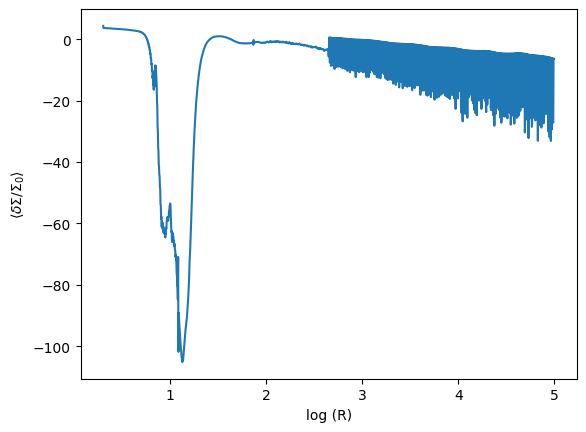

In [12]:
vortensity_average = -1*np.average(vortensity, axis=0)
vortensity_0 = ((2 +1.5)*r_c**(-3/2))/ (r_c**(-1.5))
plt.plot(r_c, -(vortensity_average - vortensity_0))
plt.xlabel('log (R)')
plt.ylabel(r'$\langle \delta \Sigma / \Sigma_0 \rangle$')

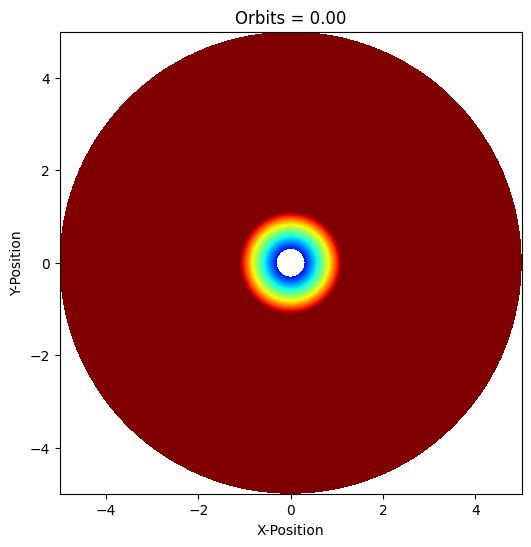

In [89]:
import glob
import matplotlib.animation as animation

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_f, phi_f)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    vortensity = data.get('user_out_var0')[0]  # [0] = first component (assumes 2D disk)

    ax.clear()
    mesh = ax.pcolormesh(X, Y, vortensity, cmap='jet', vmin = 0.0, vmax = 0.03)
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.axis('square')
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie2.gif", writer='pillow', fps=5)
# plt.show()